In [75]:
import numpy as np


# Maximum loan-to-value (LTV) vector
m = np.array([0.8, 0.75, 0.7])

# Liquidation thresholds
h = np.array([0.85, 0.8, 0.75])


# Define the initial parameters
n_assets = 3
T = 120

# Initial capital
V0 = 10

# Capital allocation vector
c = np.array([0, 0, 10], dtype=float)

# Initial borrowing weights
wb0 = np.array([7, 0, 0], dtype=float)

# Initial borrowed allocation
y = np.array([0, 0, 7], dtype=float)

# Initial long weights
wl0 = c + y

# Health factor function
def health_factor(wl, wb, h):
    total_wb = np.sum(wb)
    if total_wb == 0:
        return np.inf  # No debt, health factor is infinite
    return np.dot(wl, h) / total_wb

# Liquidation algorithm
def liquidation(wl, wb, h):
    while health_factor(wl, wb, h) < 1 and wl.sum() > 0:
        i_star = np.argmax(wl)
        j_star = np.argmax(wb)

        delta_wb = 0.5 * wb[j_star]
        lb_factor = 0.05  # Assumed liquidation bonus for simplicity
        delta_wl = delta_wb * (1 + lb_factor)

        wl[i_star] -= delta_wl
        wb[j_star] -= delta_wb

    return wl, wb


wl = wl0.copy()
wb = wb0.copy()

# Simulate wealth process
portfolio_values = [np.sum(wl)-np.sum(wb)]
health_factors = [np.sum(wl*h)/np.sum(wb)]

for t in range(T):
    # Simulated returns (random for demonstration)
    rl = np.random.normal(0.01, 0.1, n_assets)
    rb = np.random.normal(-0.01, 0.1, n_assets)

    wl *= np.exp(rl)
    wb *= np.exp(rb)

    # Check and process liquidation
    if health_factor(wl, wb, h) < 1:
        wl, wb = liquidation(wl, wb, h)

    portfolio_value = np.sum(wl) - np.sum(wb)

        
    portfolio_values.append(portfolio_value)
    health_factors.append(health_factor(wl, wb, h))
    if portfolio_value < 0:
        portfolio_value = 0
        break

# Output results
print("Portfolio Values Over Time:", portfolio_values)
print("Health Factors Over Time:", health_factors)


Portfolio Values Over Time: [10.0, 10.607951223324761, 9.99888274894344, 10.406566607145802, 11.298416111045356, 10.794969521549486, 11.95855708840806, 14.656255797123068, 17.16320261533315, 19.021789031195738, 16.096169890806074, 17.307229614664116, 21.918940529683002, 19.67025812213351, 23.081237058600216, 22.042317353963618, 19.99811270649928, 13.954582624198714, 15.662011035627426, 14.322145977010782, 11.163861226529297, 13.640829289364628, 14.601028194624941, 13.087367977384082, 11.915984572230979, 9.233082626724121, 13.99513241344364, 15.867863132108761, 10.528273825526558, 7.641967202496154, 10.196093609182807, 8.909890051778042, 9.60181063351461, 8.22359936958621, 5.960176638758913, 6.748322767494065, 4.588480429530309, 4.67985923225147, 5.757304412943281, 6.901533247853102, 7.635327312722945, 7.1963696872849265, 6.69641276020326, 7.252625704487646, 8.855146354474943, 7.137887946639012, 9.48140245867322, 10.8595156350062, 10.209669259782624, 15.028149377838409, 15.1020312720957

In [81]:
wb0 

array([7., 0., 0.])

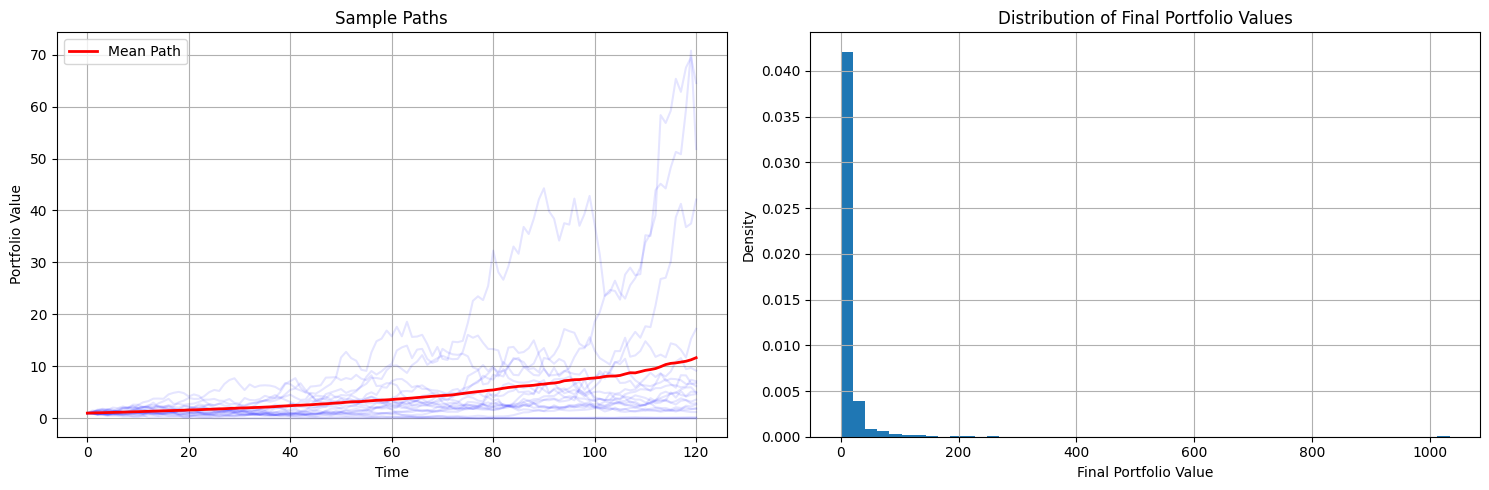

Mean final value: 11.66
Median final value: 3.88
95% VaR: 0.00
Standard deviation: 38.71


In [87]:

def simulate_portfolio(wl0, wb0, mu_l, mu_b, sigma, T, n_sims=1000):
    """
    Run Monte Carlo simulation of portfolio values
    
    Parameters:
    - wl0, wb0: Initial weights
    - mu_l, mu_b: Mean returns for long and borrowed positions
    - sigma: Covariance matrix
    - T: Time horizon
    - n_sims: Number of simulations
    """
    final_values = []
    all_paths = []
    
    for sim in range(n_sims):
        wl = wl0.copy()
        wb = wb0.copy()
        path_values = [np.sum(wl)-np.sum(wb)]
        
        for t in range(T):
            # Generate correlated returns
            rl = np.random.multivariate_normal(mu_l, sigma)
            rb = np.random.multivariate_normal(mu_b, sigma)
            
            wl *= np.exp(rl)
            wb *= np.exp(rb)
            
            # Check and process liquidation
            if health_factor(wl, wb, h) < 1:
                wl, wb = liquidation(wl, wb, h)
            
            portfolio_value = np.sum(wl) - np.sum(wb)
            path_values.append(portfolio_value)
            
            if portfolio_value < 0:
                path_values.extend([0] * (T - t - 1))
                break
                
        final_values.append(path_values[-1])
        all_paths.append(path_values)
    
    return np.array(final_values), np.array(all_paths)

# Set simulation parameters
mu_l = np.array([0.01, 0.01, 0.01])  # mean returns for long positions
mu_b = np.array([-0.01, -0.01, -0.01])  # mean returns for borrowed positions
sigma = np.array([
    [0.01, 0.005, 0.003],
    [0.005, 0.02, 0.004],
    [0.003, 0.004, 0.015]
])

# Run simulation
final_values, all_paths = simulate_portfolio(wl0, wb0, mu_l, mu_b, sigma, T, n_sims=1000)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot sample paths
for path in all_paths[::50]:  # Plot every 50th path to avoid overcrowding
    ax1.plot(path, alpha=0.1, color='blue')
ax1.plot(np.mean(all_paths, axis=0), color='red', linewidth=2, label='Mean Path')
ax1.set_title('Sample Paths')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio Value')
ax1.grid(True)
ax1.legend()

# Plot final distribution
ax2.hist(final_values, bins=50, density=True)
ax2.set_title('Distribution of Final Portfolio Values')
ax2.set_xlabel('Final Portfolio Value')
ax2.set_ylabel('Density')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Mean final value: {np.mean(final_values):.2f}")
print(f"Median final value: {np.median(final_values):.2f}")
print(f"95% VaR: {np.percentile(final_values, 5):.2f}")
print(f"Standard deviation: {np.std(final_values):.2f}")

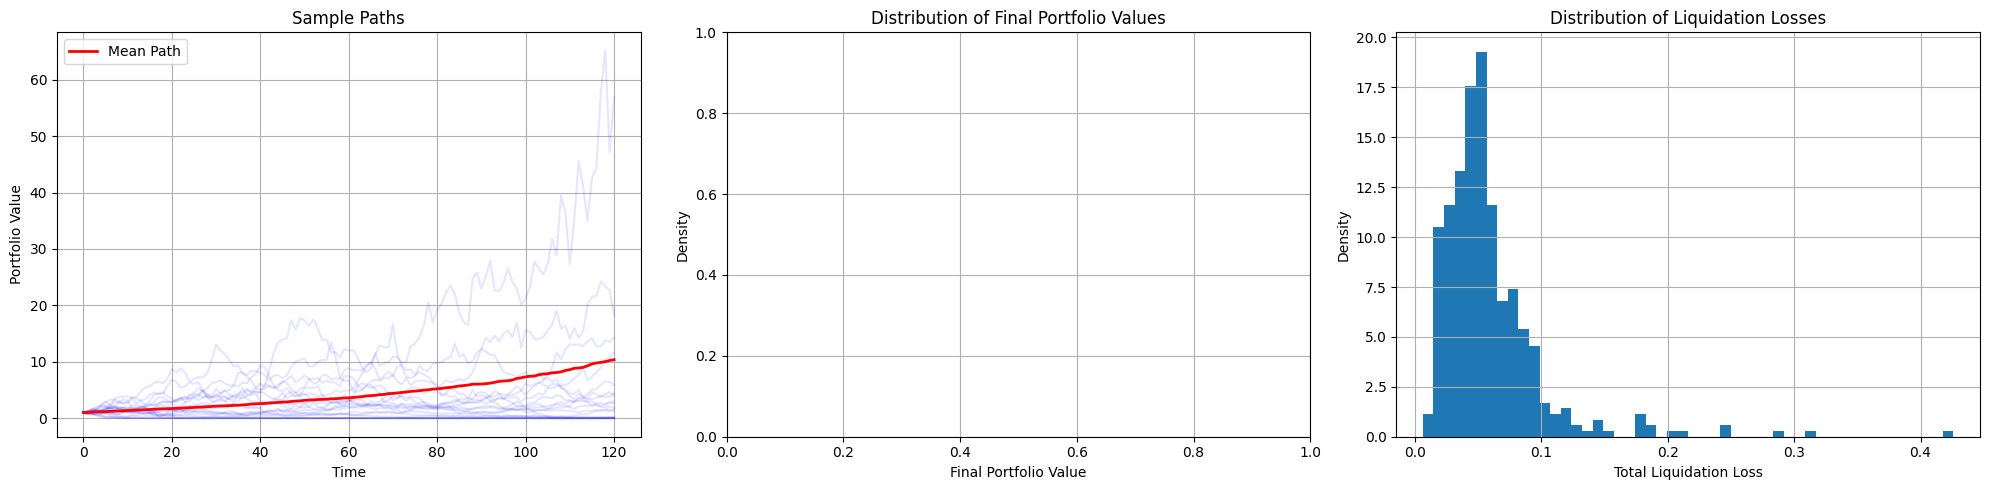


Portfolio Statistics:
Mean final value: 10.36
Median final value: 3.03
95% VaR: 0.00
Standard deviation: 24.14
Proportion of killed paths: 11.6%

non-zero Portfolio Statistics:
Mean non-zero final value: 11.72
Median  non-zero final value: 3.91
non-zero 95% VaR: 0.01
non-zero Standard deviation: 25.36

Liquidation Statistics:
Mean liquidation loss: 0.06
Median liquidation loss: 0.05
95th percentile loss: 0.12
Paths with liquidations: 42.0%


In [108]:
# Capital allocation vector
c = np.array([0, 0, 1], dtype=float)

# Initial borrowing weights
wb0 = np.array([.0, .35, 0], dtype=float)

# Initial borrowed allocation
y = np.array([0, 0, .35], dtype=float)

# Initial long weights
wl0 = c + y


def simulate_portfolio(wl0, wb0, mu_l, mu_b, sigma, T, n_sims=1000):
    """
    Run Monte Carlo simulation of portfolio values with liquidation loss tracking
    
    Parameters:
    - wl0, wb0: Initial weights
    - mu_l, mu_b: Mean returns for long and borrowed positions
    - sigma: Covariance matrix
    - T: Time horizon
    - n_sims: Number of simulations
    """
    final_values = []
    all_paths = []
    liquidation_losses = []  # Track losses from liquidation
    
    for sim in range(n_sims):
        wl = wl0.copy()
        wb = wb0.copy()
        path_values = [np.sum(wl)-np.sum(wb)]
        total_liquidation_loss = 0  # Track losses for this path
        
        for t in range(T):
            # Store pre-liquidation values
            pre_liq_value = np.sum(wl) - np.sum(wb)
            
            # Generate correlated returns
            rl = np.random.multivariate_normal(mu_l, sigma)
            rb = np.random.multivariate_normal(mu_b, sigma)
            
            wl *= np.exp(rl)
            wb *= np.exp(rb)
            
            # Check and process liquidation
            if health_factor(wl, wb, h) < 1:
                wl_pre = wl.copy()
                wb_pre = wb.copy()
                wl, wb = liquidation(wl, wb, h)
                
                # Calculate liquidation loss
                loss = (np.sum(wl_pre) - np.sum(wb_pre)) - (np.sum(wl) - np.sum(wb))
                total_liquidation_loss += max(0, loss)  # Only count positive losses
            
            portfolio_value = np.sum(wl) - np.sum(wb)
            path_values.append(portfolio_value)
            
            if portfolio_value < 0:
                path_values.extend([0] * (T - t - 1))
                break
                
        final_values.append(path_values[-1])
        all_paths.append(path_values)
        liquidation_losses.append(total_liquidation_loss)
    
    return np.array(final_values), np.array(all_paths), np.array(liquidation_losses)

# Run simulation
final_values, all_paths, liquidation_losses = simulate_portfolio(wl0, wb0, mu_l, mu_b, sigma, T, n_sims=1000)

# Plot results with liquidation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot sample paths
for path in all_paths[::50]:
    ax1.plot(path, alpha=0.1, color='blue')
ax1.plot(np.mean(all_paths, axis=0), color='red', linewidth=2, label='Mean Path')
ax1.set_title('Sample Paths')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio Value')
ax1.grid(True)
ax1.legend()

# Plot final distribution
# ax2.hist(final_values, bins=100, density=True)
ax2.set_title('Distribution of Final Portfolio Values')
ax2.set_xlabel('Final Portfolio Value')
ax2.set_ylabel('Density')
ax2.grid(True)

# Plot liquidation losses distribution
ax3.hist(liquidation_losses[liquidation_losses>0], bins=50, density=True)
ax3.set_title('Distribution of Liquidation Losses')
ax3.set_xlabel('Total Liquidation Loss')
ax3.set_ylabel('Density')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPortfolio Statistics:")
print(f"Mean final value: {np.mean(final_values):.2f}")
print(f"Median final value: {np.median(final_values):.2f}")
print(f"95% VaR: {np.percentile(final_values, 5):.2f}")
print(f"Standard deviation: {np.std(final_values):.2f}")
print(f"Proportion of killed paths: {np.mean(final_values <= 0):.1%}")


non_zero_final_values = final_values[final_values > 0]  # Filter out zero or negative final values
print("\nnon-zero Portfolio Statistics:")
print(f"Mean non-zero final value: {np.mean(non_zero_final_values):.2f}")
print(f"Median  non-zero final value: {np.median(non_zero_final_values):.2f}")
print(f"non-zero 95% VaR: {np.percentile(non_zero_final_values, 5):.2f}")
print(f"non-zero Standard deviation: {np.std(non_zero_final_values):.2f}")
ax2.hist(non_zero_final_values, bins=100, density=True)


print("\nLiquidation Statistics:")
print(f"Mean liquidation loss: {np.mean(liquidation_losses[liquidation_losses>0]):.2f}")
print(f"Median liquidation loss: {np.median(liquidation_losses[liquidation_losses>0]):.2f}")
print(f"95th percentile loss: {np.percentile(liquidation_losses[liquidation_losses>0], 95):.2f}")
print(f"Paths with liquidations: {np.sum(liquidation_losses > 0) / len(liquidation_losses):.1%}")

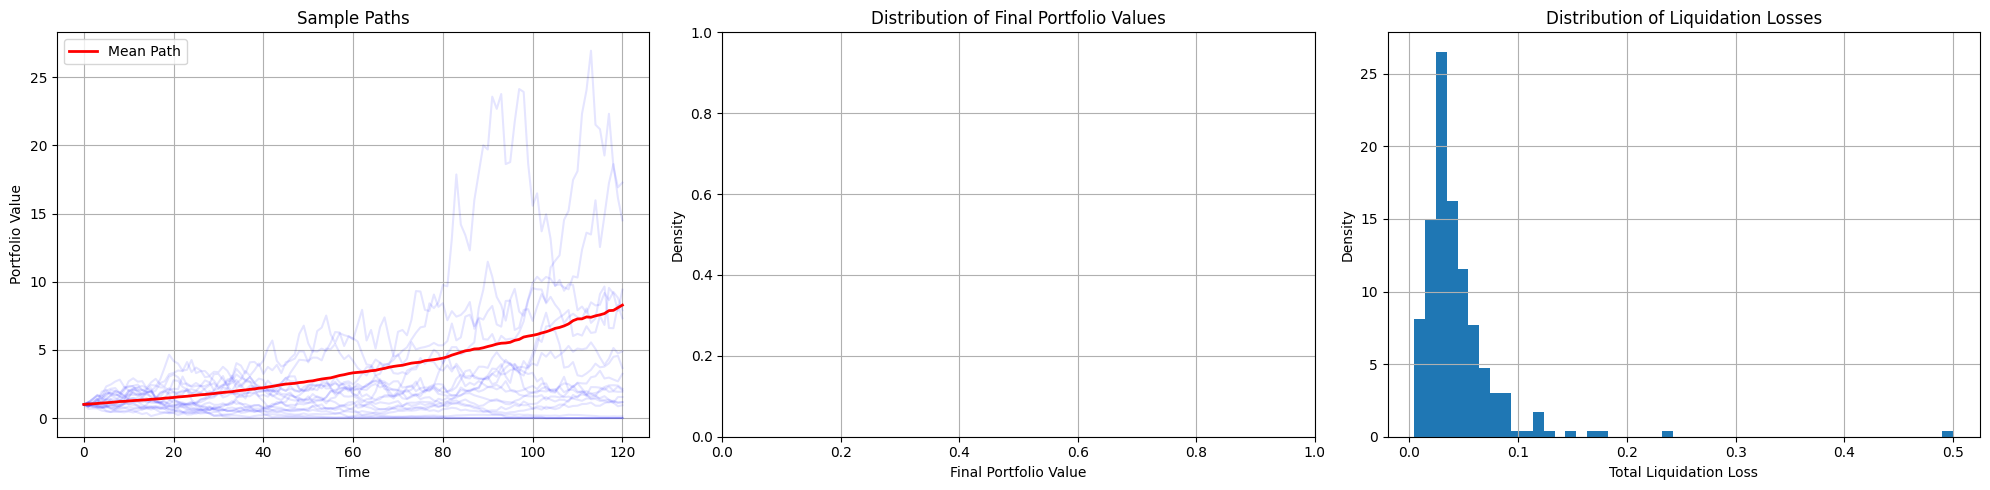


Portfolio Statistics:
Mean final value: 8.28
Median final value: 3.23
95% VaR: 0.00
Standard deviation: 14.91
Proportion of killed paths: 7.0%

non-zero Portfolio Statistics:
Mean non-zero final value: 8.91
Median  non-zero final value: 3.85
non-zero 95% VaR: 0.04
non-zero Standard deviation: 15.28

Liquidation Statistics:
Mean liquidation loss: 0.04
Median liquidation loss: 0.03
95th percentile loss: 0.10
Paths with liquidations: 23.6%


In [109]:
# Capital allocation vector
c = np.array([0, 0, 1], dtype=float)

# Initial borrowing weights
wb0 = np.array([.0, .35, 0], dtype=float)

# Initial borrowed allocation
y = np.array([0, 0, .35], dtype=float)

# Initial long weights
wl0 = c + y


def simulate_portfolio(wl0, wb0, mu_l, mu_b, sigma, T, n_sims=1000):
    """
    Run Monte Carlo simulation of portfolio values with liquidation loss tracking
    
    Parameters:
    - wl0, wb0: Initial weights
    - mu_l, mu_b: Mean returns for long and borrowed positions
    - sigma: Covariance matrix
    - T: Time horizon
    - n_sims: Number of simulations
    """
    final_values = []
    all_paths = []
    liquidation_losses = []  # Track losses from liquidation
    
    for sim in range(n_sims):
        wl = wl0.copy()
        wb = wb0.copy()
        path_values = [np.sum(wl)-np.sum(wb)]
        total_liquidation_loss = 0  # Track losses for this path
        
        for t in range(T):
            # Store pre-liquidation values
            pre_liq_value = np.sum(wl) - np.sum(wb)
            
            # Generate correlated returns
            rl = np.random.multivariate_normal(mu_l, sigma)
            rb = np.random.multivariate_normal(mu_b, sigma)
            
            wl *= np.exp(rl)
            wb *= np.exp(rb)
            
            # Check and process liquidation
            if health_factor(wl, wb, h) < 1:
                wl_pre = wl.copy()
                wb_pre = wb.copy()
                wl, wb = liquidation(wl, wb, h)
                
                # Calculate liquidation loss
                loss = (np.sum(wl_pre) - np.sum(wb_pre)) - (np.sum(wl) - np.sum(wb))
                total_liquidation_loss += max(0, loss)  # Only count positive losses
            
            portfolio_value = np.sum(wl) - np.sum(wb)
            path_values.append(portfolio_value)
            
            if portfolio_value < 0:
                path_values.extend([0] * (T - t - 1))
                break
                
        final_values.append(path_values[-1])
        all_paths.append(path_values)
        liquidation_losses.append(total_liquidation_loss)
    
    return np.array(final_values), np.array(all_paths), np.array(liquidation_losses)

# Run simulation
final_values, all_paths, liquidation_losses = simulate_portfolio(wl0, wb0, mu_l, mu_b, sigma, T, n_sims=1000)

# Plot results with liquidation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot sample paths
for path in all_paths[::50]:
    ax1.plot(path, alpha=0.1, color='blue')
ax1.plot(np.mean(all_paths, axis=0), color='red', linewidth=2, label='Mean Path')
ax1.set_title('Sample Paths')
ax1.set_xlabel('Time')
ax1.set_ylabel('Portfolio Value')
ax1.grid(True)
ax1.legend()

# Plot final distribution
# ax2.hist(final_values, bins=100, density=True)
ax2.set_title('Distribution of Final Portfolio Values')
ax2.set_xlabel('Final Portfolio Value')
ax2.set_ylabel('Density')
ax2.grid(True)

# Plot liquidation losses distribution
ax3.hist(liquidation_losses[liquidation_losses>0], bins=50, density=True)
ax3.set_title('Distribution of Liquidation Losses')
ax3.set_xlabel('Total Liquidation Loss')
ax3.set_ylabel('Density')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPortfolio Statistics:")
print(f"Mean final value: {np.mean(final_values):.2f}")
print(f"Median final value: {np.median(final_values):.2f}")
print(f"95% VaR: {np.percentile(final_values, 5):.2f}")
print(f"Standard deviation: {np.std(final_values):.2f}")
print(f"Proportion of killed paths: {np.mean(final_values <= 0):.1%}")


non_zero_final_values = final_values[final_values > 0]  # Filter out zero or negative final values
print("\nnon-zero Portfolio Statistics:")
print(f"Mean non-zero final value: {np.mean(non_zero_final_values):.2f}")
print(f"Median  non-zero final value: {np.median(non_zero_final_values):.2f}")
print(f"non-zero 95% VaR: {np.percentile(non_zero_final_values, 5):.2f}")
print(f"non-zero Standard deviation: {np.std(non_zero_final_values):.2f}")
ax2.hist(non_zero_final_values, bins=100, density=True)


print("\nLiquidation Statistics:")
print(f"Mean liquidation loss: {np.mean(liquidation_losses[liquidation_losses>0]):.2f}")
print(f"Median liquidation loss: {np.median(liquidation_losses[liquidation_losses>0]):.2f}")
print(f"95th percentile loss: {np.percentile(liquidation_losses[liquidation_losses>0], 95):.2f}")
print(f"Paths with liquidations: {np.sum(liquidation_losses > 0) / len(liquidation_losses):.1%}")

/Users/francis/opt/anaconda3/envs/py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


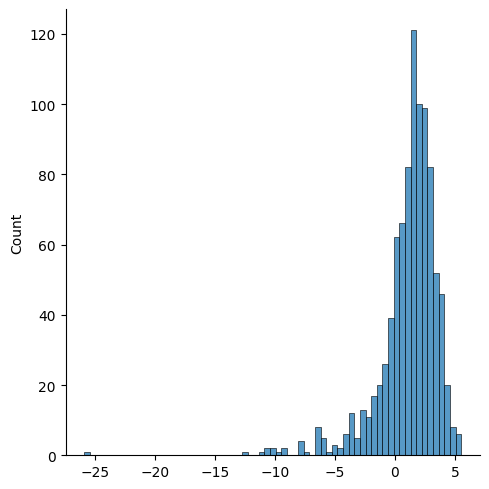

In [103]:
import seaborn as sns

sns.displot(np.log(non_zero_final_values))

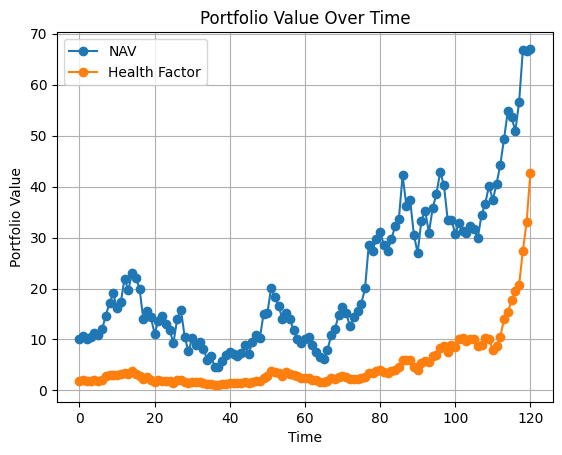

In [76]:
import matplotlib.pyplot as plt

plt.plot(range(len(portfolio_values)), portfolio_values, marker='o', label='NAV')
plt.plot(range(len(portfolio_values)), health_factors, marker='o', label='Health Factor')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(True)
plt.show()

In [2]:
from os import listdir
files = listdir('data')

In [3]:
variableBorrowRates = dict()
utilizationRates = dict()
for file_name in files:
    f = pd.read_csv('data/'+file_name)
    _id = (f.variableBorrowRate_avg == 0) 
    
    f = f.loc[~_id]
    
    f = f.loc[~f.x.isna()]

    rate = pd.Series(list(f.variableBorrowRate_avg), index = pd.to_datetime(f.x))
    utilization = pd.Series(list(f.utilizationRate_avg), index = pd.to_datetime(f.x))
    variableBorrowRates[file_name[:4]] = rate
    utilizationRates[file_name[:4]] = utilization
    

In [4]:
from scipy.optimize import fsolve, fmin, root_scalar, minimize


lambda_1 = 3   # Example value for lambda^{(1)}
lambda_2 = 1    # Example value for lambda^{(2)}
gamma = 0.5     # Example value for gamma      
r1 = 0.1*lambda_1        # Example value for r_1
r2 = 0.1*lambda_2        # Example value for r_2
mu = 0.1         # Example value for mu
sigma = 0.5       # Example value for sigma

def wrapper(lambda_1, lambda_2, gamma, r1, r2, mu, sigma):
    def FOC_CRRA(p):
        lhs = lambda_1*(1-p)**(gamma-1) - lambda_2*p**(gamma-1)
        rhs = (r1-r2-mu) - (1-p)*sigma**2 *(gamma-1)
        return lhs - rhs
    bracket = [0.001, .999]
    res = root_scalar(FOC_CRRA, bracket=bracket, method='brentq')
    return res.root
    


In [5]:
_id = variableBorrowRates['USDT'].index > '2023-01-01'
_id *= variableBorrowRates['USDT'].index < '2024-01-01'

USDT_r = variableBorrowRates['USDT'] * utilizationRates['USDT']
USDT_r = USDT_r.loc[_id]

ETH_r = variableBorrowRates['WETH'] * utilizationRates['WETH']
_id = ETH_r.index > '2023-01-01'
_id *= ETH_r.index < '2024-01-01'
ETH_r = ETH_r.loc[_id]

rates = pd.concat([USDT_r, ETH_r], axis=1)
rates = rates.dropna()

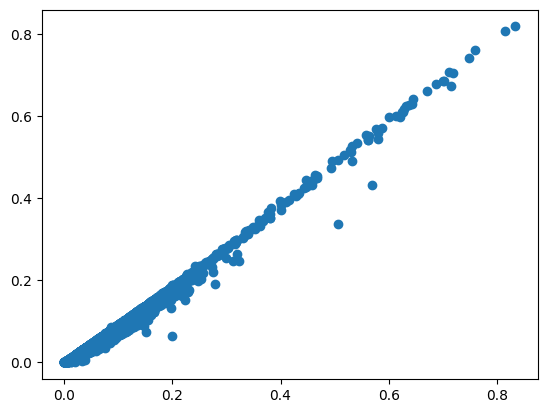

In [6]:
x = variableBorrowRates['USDT']
y = variableBorrowRates['USDT'] * utilizationRates['USDT'] 
plt.scatter(x,y)

In [7]:
res = dict()

gamma = 0.1     # Example value for gamma      
mu = 0.1         # Example value for mu
sigma = 0.5       # Example value for sigma

for i in range(len(rates)):
    r1 = rates.iloc[i, 0]
    r2 = rates.iloc[i, 1]
    lambda_1 = 0.1
    lambda_2 = 0.1
    gamma = 0.2
    w = wrapper(lambda_1, lambda_2, gamma, r1, r2, mu, sigma)
    
    res[rates.index[i]] = w
    
res = pd.Series(res)

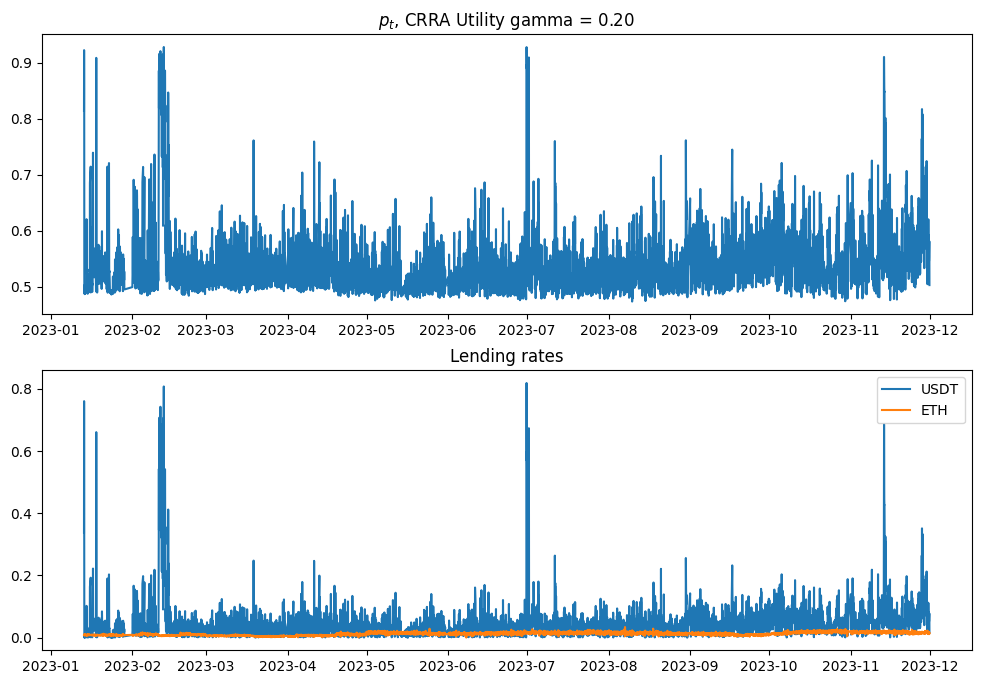

In [8]:
f, ax = plt.subplots(2, figsize=(12,8))
ax[0].plot(res)
ax[0].set_title(r'$p_t$, CRRA Utility gamma = %.2f'%gamma)

ax[1].plot(rates.loc[:,0], label='USDT')
ax[1].plot(rates.loc[:,1], label='ETH')
ax[1].set_title('Lending rates')
plt.legend()

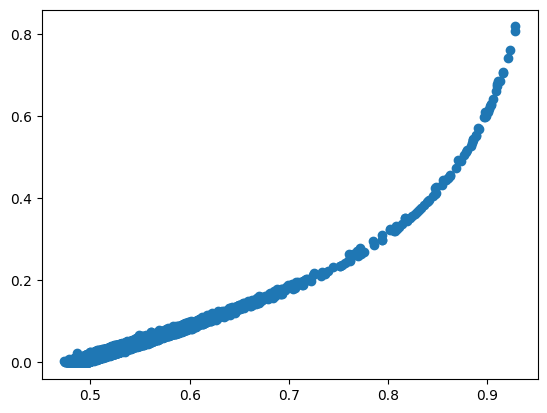

In [9]:
plt.scatter(res, rates.loc[:,0])

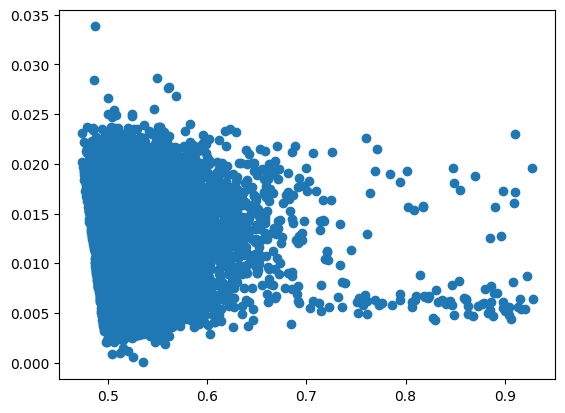

In [10]:
plt.scatter(res, rates.loc[:,1])

In [25]:
rates_space = np.linspace(0,1,20)

rates = np.array(np.meshgrid(rates_space, rates_space)).T.reshape(-1,2)

rates = pd.DataFrame(rates)

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
res = dict()
mu = 0.05

for i in range(len(rates)):
    r1 = rates.iloc[i, 0]
    r2 = rates.iloc[i, 1]
    lambda_1 = r1
    lambda_2 = r2
    gamma = 0.4
    w = wrapper(lambda_1, lambda_2, gamma, r1, r2, mu, sigma)
    
    res[i] = w
    
res = pd.Series(res)
res = pd.concat([rates, res],axis=1)
res.columns = ['r1', 'r2', 'p']

Text(0.5, 0, '$p^*$')

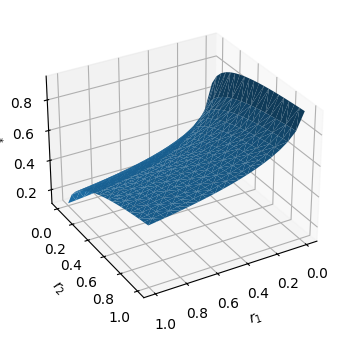

In [33]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=None, azim=60, roll=None, vertical_axis='z')

ax.plot_trisurf(res['r1'], res['r2'], res['p'], linewidth=1, alpha=1)
ax.set_xlabel(r'$r_1$')
ax.set_ylabel(r'$r_2$')
ax.set_zlabel(r'$p^*$')


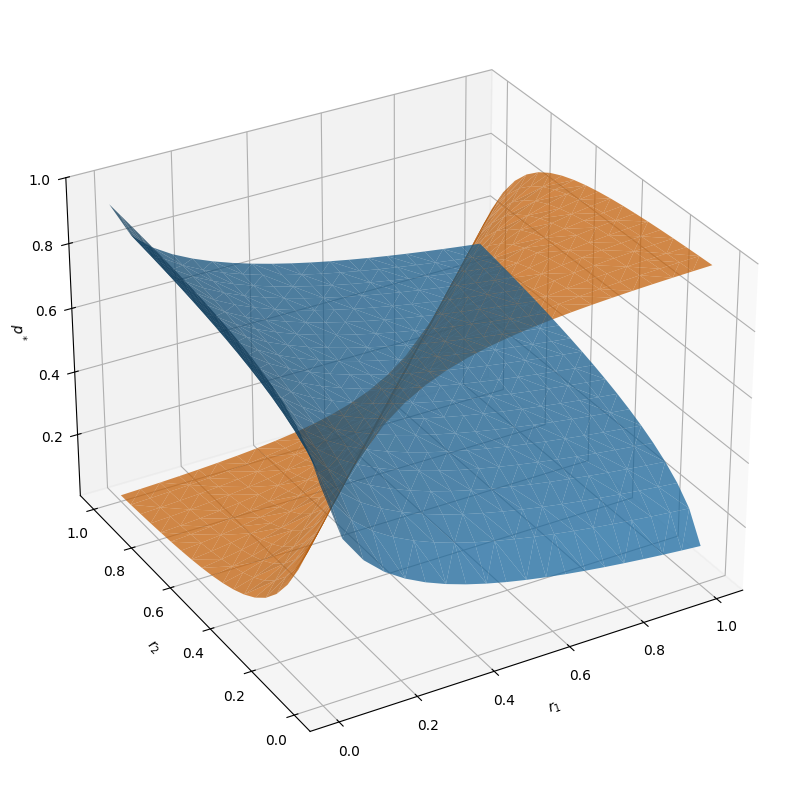

In [50]:
res2 = dict()
mu = 0.05

for i in range(len(rates)):
    r1 = rates.iloc[i, 0]
    r2 = rates.iloc[i, 1]
    lambda_1 = 0.1
    lambda_2 = 0.1
    gamma = 0.4
    w = wrapper(lambda_1, lambda_2, gamma, r1, r2, mu, sigma)
    
    res2[i] = w
    
res2 = pd.Series(res2)
res2 = pd.concat([rates, res2],axis=1)
res2.columns = ['r1', 'r2', 'p']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=None, azim=-120, roll=None, vertical_axis='z')

ax.plot_trisurf(res['r1'], res['r2'], res['p'], linewidth=1, alpha=0.75)
ax.plot_trisurf(res2['r1'], res2['r2'], res2['p'], linewidth=1, alpha=0.75)

ax.set_xlabel(r'$r_1$')
ax.set_ylabel(r'$r_2$')
ax.set_zlabel(r'$p^*$')

plt.show()

In [49]:
import plotly.express as px

fig = px.scatter_3d(res, x='r1', y='r2', z='p')
fig.show()
fig = px.scatter_3d(res2, x='r1', y='r2', z='p')
fig.show()


In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
z = z_data.values
z.shape

(25, 25)